<a href="https://colab.research.google.com/github/SeanUlep/301-Submissions/blob/main/Gradient_Boost_Using_Jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [332]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [333]:
# uncomment this if running locally or on Google Colab
!pip install --upgrade hepml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [334]:
# data wrangling
import pandas as pd
import jax as JA
import numpy as np

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [335]:
number_of_examples = 100
# fix the seed for reproducibility
key = JA.random.PRNGKey(42)
np.random.seed(42)
# generate features
X = (JA.random.normal(key, shape=(100, 1)) - 0.15) / 5
#X = np.random.rand(number_of_examples, 1) - 0.5
# generate target
#y = 3 * X[:, 0] ** 2 + 0.05 * JA.random.normal(key, shape=(number_of_examples,))
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(number_of_examples)
# create pandas.DataFrame
data = pd.DataFrame(data=np.stack([X[:, 0], y], axis=1), columns=["X", "y"])
data.head()

,X,y
0,0.066087,0.037938
1,0.285870,0.238252
2,0.220858,0.178719
3,-0.077882,0.094348
4,-0.236128,0.155562


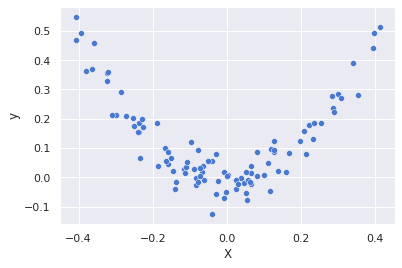

In [336]:
sns.scatterplot(x="X", y="y", data=data)
plt.show()

In [337]:
tree_1 = DecisionTreeRegressor(max_depth=2)
tree_1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [338]:
data["Tree 1 prediction"] = tree_1.predict(X)
data.head()

,X,y,Tree 1 prediction
0,0.066087,0.037938,0.057167
1,0.285870,0.238252,0.341150
2,0.220858,0.178719,0.057167
3,-0.077882,0.094348,0.057167
4,-0.236128,0.155562,0.057167


In [339]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    plt.ylabel("$y$", fontsize=16)
    plt.xlabel("$X$", fontsize=16)

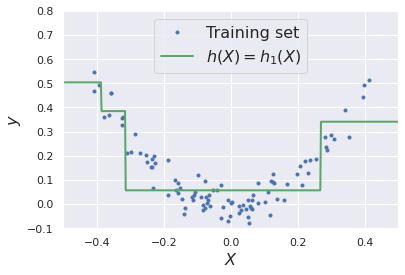

In [340]:
plot_predictions(
    [tree_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(X)=h_1(X)$", style="g-", data_label="Training set"
)
plt.show()

In [341]:
data["Tree 1 residual"] = data["y"] - data["Tree 1 prediction"]
data.head()

,X,y,Tree 1 prediction,Tree 1 residual
0,0.066087,0.037938,0.057167,-0.019229
1,0.285870,0.238252,0.341150,-0.102898
2,0.220858,0.178719,0.057167,0.121552
3,-0.077882,0.094348,0.057167,0.037181
4,-0.236128,0.155562,0.057167,0.098395


In [342]:
tree_2 = DecisionTreeRegressor(max_depth=2)
tree_2.fit(X, data["Tree 1 residual"])

DecisionTreeRegressor(max_depth=2)

In [343]:
data["Tree 2 prediction"] = tree_2.predict(X)
data["Tree 1 + tree 2 prediction"] = sum(tree.predict(X) for tree in (tree_1, tree_2))
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction
0,0.066087,0.037938,0.057167,-0.019229,-0.046161,0.011005
1,0.285870,0.238252,0.341150,-0.102898,0.031842,0.372993
2,0.220858,0.178719,0.057167,0.121552,0.031842,0.089009
3,-0.077882,0.094348,0.057167,0.037181,-0.046161,0.011005
4,-0.236128,0.155562,0.057167,0.098395,0.129411,0.186578


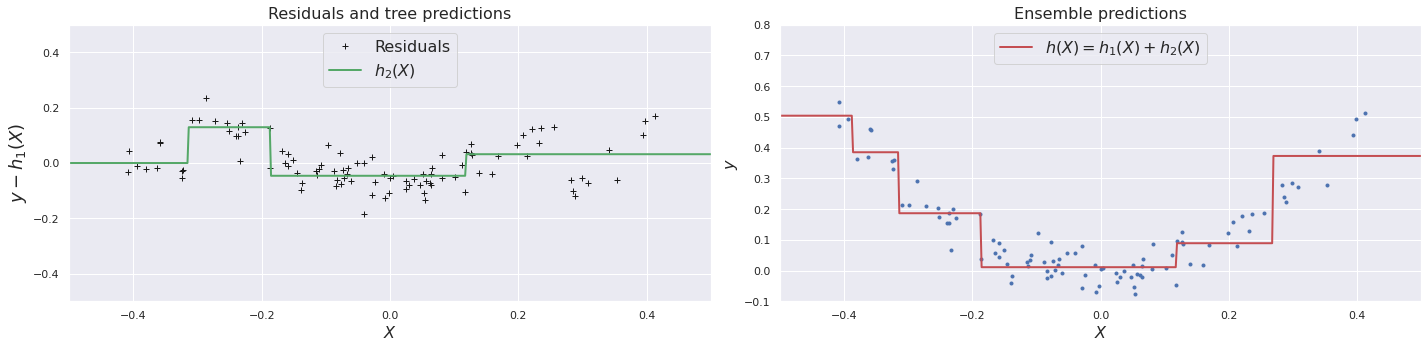

In [344]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

plt.subplot(ax0)
plot_predictions(
    [tree_2],
    X,
    data["Tree 1 residual"],
    axes=[-0.5, 0.5, -0.5, 0.5],
    label="$h_2(X)$",
    style="g-",
    data_style="k+",
    data_label="Residuals",
)
plt.ylabel("$y - h_1(X)$", fontsize=18)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(ax1)
plot_predictions([tree_1, tree_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(X) = h_1(X) + h_2(X)$")
plt.title("Ensemble predictions", fontsize=16)
plt.tight_layout()

In [345]:
data["Tree 1 + tree 2 residual"] = data["Tree 1 residual"] - data["Tree 2 prediction"]
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction,Tree 1 + tree 2 residual
0,0.066087,0.037938,0.057167,-0.019229,-0.046161,0.011005,0.026933
1,0.285870,0.238252,0.341150,-0.102898,0.031842,0.372993,-0.134740
2,0.220858,0.178719,0.057167,0.121552,0.031842,0.089009,0.089710
3,-0.077882,0.094348,0.057167,0.037181,-0.046161,0.011005,0.083343
4,-0.236128,0.155562,0.057167,0.098395,0.129411,0.186578,-0.031016


In [346]:
tree_3 = DecisionTreeRegressor(max_depth=2)
tree_3.fit(X, data["Tree 1 + tree 2 residual"])

DecisionTreeRegressor(max_depth=2)

In [347]:
data["Tree 3 prediction"] = tree_3.predict(X)
data["Tree 1 + tree 2 + tree 3 prediction"] = sum(tree.predict(X) for tree in (tree_1, tree_2, tree_3))
data["Final residual"] = data["Tree 1 + tree 2 residual"] - data["Tree 3 prediction"]
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction,Tree 1 + tree 2 residual,Tree 3 prediction,Tree 1 + tree 2 + tree 3 prediction,Final residual
0,0.066087,0.037938,0.057167,-0.019229,-0.046161,0.011005,0.026933,0.003538,0.014544,0.023395
1,0.285870,0.238252,0.341150,-0.102898,0.031842,0.372993,-0.134740,-0.092368,0.280625,-0.042372
2,0.220858,0.178719,0.057167,0.121552,0.031842,0.089009,0.089710,0.003538,0.092547,0.086172
3,-0.077882,0.094348,0.057167,0.037181,-0.046161,0.011005,0.083343,0.003538,0.014544,0.079805
4,-0.236128,0.155562,0.057167,0.098395,0.129411,0.186578,-0.031016,0.003538,0.190116,-0.034554


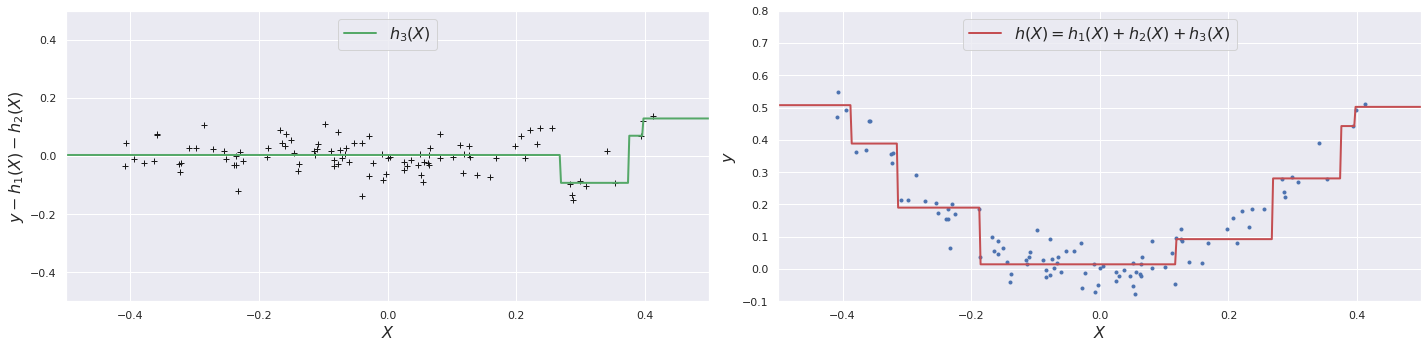

In [348]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

plt.subplot(ax0)
plot_predictions(
    [tree_3],
    X,
    data["Tree 1 + tree 2 residual"],
    axes=[-0.5, 0.5, -0.5, 0.5],
    label="$h_3(X)$",
    style="g-",
    data_style="k+",
)
plt.ylabel("$y - h_1(X) - h_2(X)$", fontsize=16)

plt.subplot(ax1)
plot_predictions(
    [tree_1, tree_2, tree_3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(X) = h_1(X) + h_2(X) + h_3(X)$",
)
plt.tight_layout()